In [18]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [20]:
df=pd.read_csv("/content/drive/MyDrive/datasets/Amazon Fine Food Reviews/Reviews.csv",nrows=10000)

df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True) #dropping na

In [21]:
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']
target_data.replace('', np.nan, inplace=True)

In [22]:
# Drop Duplicates and NA values
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9513 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      9513 non-null   int64 
 1   ProductId               9513 non-null   object
 2   UserId                  9513 non-null   object
 3   ProfileName             9513 non-null   object
 4   HelpfulnessNumerator    9513 non-null   int64 
 5   HelpfulnessDenominator  9513 non-null   int64 
 6   Score                   9513 non-null   int64 
 7   Time                    9513 non-null   int64 
 8   Summary                 9513 non-null   object
 9   Text                    9513 non-null   object
dtypes: int64(5), object(5)
memory usage: 817.5+ KB


In [23]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [24]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]

contractions = contraction_mapping

#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

##Data Cleaning

In [25]:
def clean(texts,src):
  texts = BeautifulSoup(texts, "lxml").text
  words=word_tokenize(texts.lower())

  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words ]

  #stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [26]:
#pass the input records and target records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

In [27]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words

#get the length of the input and target texts which appears most often
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])

print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  10353
number of target words :  4173
maximum input length :  73
maximum target length :  19


In [28]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0)

In [29]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)

#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train)
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [30]:
#pad array of 0's if the length is less than the maximum length
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post')
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')

#decoder input data will not include the last word
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

##Model Building

In [31]:
K.clear_session()
latent_dim = 500

#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,))
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs)

In [33]:
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True)
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding)

#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True)
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1)

#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)

#encoder states
en_states= [state_h3, state_c3]

In [34]:
# Decoder.
dec_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_tr_words+1, latent_dim)
dec_embedding = dec_emb_layer(dec_inputs)

#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states)

In [35]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])

#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [36]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax')
dec_outputs = dec_dense(merge)

##Train the Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 73)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 73, 500)              5177000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 73, 500),            2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                        
                                                                                              

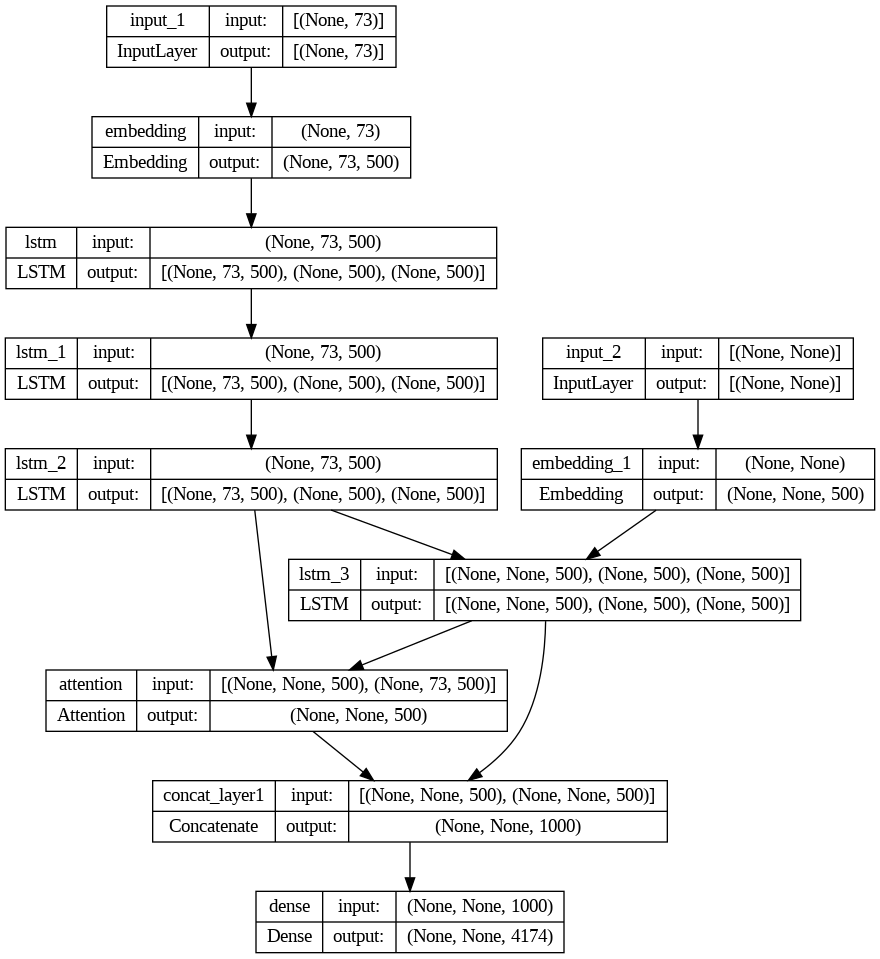

In [37]:
model = Model([en_inputs, dec_inputs], dec_outputs)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
history = model.fit(
                    [en_in_data, dec_in_data],
                    dec_tr_data,
                    batch_size=512,
                    epochs=10,
                    validation_split=0.1,)

14/14 [==============================] - 571s 40s/step - loss: 1.3912 - accuracy: 0.7972 - val_loss: 1.3113 - val_accuracy: 0.8002


In [47]:
# encoder inference
latent_dim=500

en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [48]:
# decoder inference

dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))

# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)

#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [49]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])

merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [50]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)

# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [51]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index

In [52]:
def decode_sequence(input_seq):
    # get the encoder output and states by passing the input sequence
    en_out, en_h, en_c = en_model.predict(input_seq)

    # target sequence with inital word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    # if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    # append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition:
        # get predicted output, hidden and cell state.
        output_words, dec_h, dec_c = dec_model.predict([target_seq] + [en_out, en_h, en_c])

        # get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word + " "

        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
            stop_condition = True

        # update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c

    # return the deocded sentence
    return decoded_sentence

In [53]:
inp_review = "Both the Google platforms provide a great cloud environment for any ML work to be deployed to. The features of them both are equally competent. Notebooks can be downloaded and later uploaded between the two. However, Colab comparatively provides greater flexibility to adjust the batch sizes.Saving or storing of models is easier on Colab since it allows them to be saved and stored to Google Drive. Also if one is using TensorFlow, using TPUs would be preferred on Colab. It is also faster than Kaggle. For a use case demanding more power and longer running processes, Colab is preferred."
print("Review :", inp_review)

inp_review = clean(inp_review, "inputs")
inp_review = ' '.join(inp_review)
inp_x = in_tokenizer.texts_to_sequences([inp_review])
inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')

summary = decode_sequence(inp_x.reshape(1, max_in_len))
if 'eos' in summary:
    summary = summary.replace('eos', '')
print("\nPredicted summary:", summary);
print("\n")

Review : Both the Google platforms provide a great cloud environment for any ML work to be deployed to. The features of them both are equally competent. Notebooks can be downloaded and later uploaded between the two. However, Colab comparatively provides greater flexibility to adjust the batch sizes.Saving or storing of models is easier on Colab since it allows them to be saved and stored to Google Drive. Also if one is using TensorFlow, using TPUs would be preferred on Colab. It is also faster than Kaggle. For a use case demanding more power and longer running processes, Colab is preferred.
1/1 [==============================] - 0s 29ms/step

Predicted summary: great  


